In [ ]:
! pip install transformers

In [1]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 17), reused 39 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), 27.83 MiB | 4.41 MiB/s, done.


In [1]:
import sys

sys.path.append('space-model')

In [2]:
import pandas as pd

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from datasets import Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

In [3]:
device_id = 0

In [4]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
torch.cuda.set_device(device)

In [6]:
train_df = pd.read_csv('data/covid_train.csv', index_col=0)
train_df

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real
...,...,...
6416,A tiger tested positive for COVID-19 please st...,fake
6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6418,_A post claims a COVID-19 vaccine has already ...,fake


In [7]:
test_df = pd.read_csv('data/covid_test.csv', index_col=0)
test_df

,tweet,label
id,,
1,Our daily update is published. States reported...,real
2,Alfalfa is the only cure for COVID-19.,fake
3,President Trump Asked What He Would Do If He W...,fake
4,States reported 630 deaths. We are still seein...,real
5,This is the sixth time a global health emergen...,real
...,...,...
2136,#CoronaVirusUpdates: State-wise details of Tot...,real
2137,Tonight 12(midnight) onwards Disaster Manageme...,fake
2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,real


In [8]:
val_df = pd.read_csv('data/covid_val.csv', index_col=0)
val_df

,tweet,label
id,,
1,Chinese converting to Islam after realising th...,fake
2,11 out of 13 people (from the Diamond Princess...,fake
3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
4,Mike Pence in RNC speech praises Donald Trump’...,fake
5,6/10 Sky's @EdConwaySky explains the latest #C...,real
...,...,...
2136,Donald Trump wrongly claimed that New Zealand ...,fake
2137,Current understanding is #COVID19 spreads most...,real
2138,Nothing screams “I am sat around doing fuck al...,fake


In [9]:
def encode_label(s: str):
    if s == 'fake':
        return 1
    else:
        return 0

In [10]:
train_df = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
train_df

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real
...,...,...
10695,#CoronaVirusUpdates: State-wise details of Tot...,real
10696,Tonight 12(midnight) onwards Disaster Manageme...,fake
10697,296 new cases of #COVID19Nigeria; Plateau-85 E...,real
10698,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,real


In [11]:
train_df['label'] = train_df['label'].apply(encode_label)
train_df

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,0
1,States reported 1121 deaths a small rise from ...,0
2,Politically Correct Woman (Almost) Uses Pandem...,1
3,#IndiaFightsCorona: We have 1524 #COVID testin...,0
4,Populous states can generate large case counts...,0
...,...,...
10695,#CoronaVirusUpdates: State-wise details of Tot...,0
10696,Tonight 12(midnight) onwards Disaster Manageme...,1
10697,296 new cases of #COVID19Nigeria; Plateau-85 E...,0
10698,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,0


<Axes: >

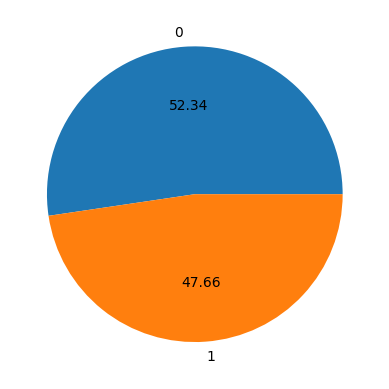

In [12]:
train_df.groupby('label').size().plot(kind='pie', autopct='%.2f')

In [44]:
EXPERIMENT_NAME = 'inter-loss'
MODEL_NAME = 'bert-base-cased'
MODELS_PATH = 'models'
DATASET_NAME = 'fake-news-net-gossip'

# SEED = 
NUM_EPOCHS = 10
BATCH_SIZE = 256
MAX_SEQ_LEN = 512
N_LATENT = 3

In [14]:
val_dataset = DatasetDict({
    'test': Dataset.from_pandas(train_df[['tweet', 'label']]),
})
val_dataset

DatasetDict({
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 10700
    })
})

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
val_dataset = val_dataset.map(lambda x: tokenizer(x['tweet'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
val_dataset.set_format('torch', device=device)
val_dataset

Map:   0%|          | 0/10700 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10700
    })
})

## Base Model

In [32]:
state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [18]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, state_dict=state_dict).to(device)
base_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

In [18]:
def concept_space_to_preds(concept_spaces):
    tensor_concept_spaces = torch.cat([cs.unsqueeze(0) for cs in concept_spaces], dim=0)
    concept_space_dist = tensor_concept_spaces.permute(1, 0, 2, 3).mean(dim=(2, 3)) # (B, n)
    return torch.argmax(concept_space_dist, dim=1).detach().cpu().tolist()

In [19]:
@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    cs_val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            ### Distance Based Classification
            # out.concept_spaces (n, B, seq_len, n_latent)
            if hasattr(outputs, 'concept_spaces'):
                cs_val_preds += concept_space_to_preds(outputs.concept_spaces)
            ### END

            val_loss += loss.item()
    return val_loss, val_preds, val_labels, cs_val_preds

In [20]:
val_dataloader = torch.utils.data.DataLoader(val_dataset['test'], batch_size=2 * BATCH_SIZE)

In [ ]:
val_loss, val_preds, val_labels, _ = eval_epoch(base_model, val_dataloader)

100%|██████████| 21/21 [03:07<00:00,  8.91s/it]


In [24]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.8171130248478481
Val acc: 0.5233644859813084
Val f1: 0.3435582822085889
Val precision: 0.2616822429906542
Val recall: 0.5


## Space Model

In [45]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [46]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=N_LATENT, n_concept_spaces=2, l1=0, l2=0).to(device)
space_model.load_state_dict(torch.load(f'{MODELS_PATH}/{EXPERIMENT_NAME}/{DATASET_NAME}_space-{MODEL_NAME}-({N_LATENT})_{NUM_EPOCHS}.bin'))
space_model

SpaceModelForSequenceClassification(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [47]:
val_loss, val_preds, val_labels, cs_val_preds = eval_epoch(space_model, val_dataloader)

100%|██████████| 21/21 [03:14<00:00,  9.28s/it]


In [48]:
cs_val_acc = accuracy_score(val_labels, cs_val_preds)
cs_val_f1 = f1_score(val_labels, cs_val_preds, average='macro')

val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'CS Val acc: {cs_val_acc}')
print(f'Val f1: {val_f1}')
print(f'CS Val f1: {cs_val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.7022485051836286
Val acc: 0.5233644859813084
CS Val acc: 0.5288785046728972
Val f1: 0.3435582822085889
CS Val f1: 0.3597856329276285
Val precision: 0.2616822429906542
Val recall: 0.5
